## Introduction

In this notebook I tried to explore the [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) from Kaggle. I have tried to look in to what is in the dataset, did exploratory data analysis, and did predictive modelling. In addition to these hypothesis testing is also included in this notebook, and all of them have thier own dedicated parts, so let's dive in.

## Imports and EDA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns
import warnings
from functions import plot_distributions, countplot_percentages, tabulate_percentage, plot_dist, t_and_z_test, reject_null, confidence_interval, get_model_with_highest_roc_score
import kaleido

In [2]:
pio.renderers.default = 'svg'

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**Categorical Features**: Gender, Ever Married, Work Type, Residence Type, and Smoking Status

**Numerical Features**: Age, Hypertension, Heart Disease, Average Glucose Level, BMI

In [6]:
df.describe().drop('id', axis=1)

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

In [7]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We have missing values in the BMI column we will treat it later.

In [8]:
df.duplicated().sum()

0

We have no duplicated entries in our dataset

In [9]:
df = df.drop('id', axis=1)

We removed the unnccessary 'id' column

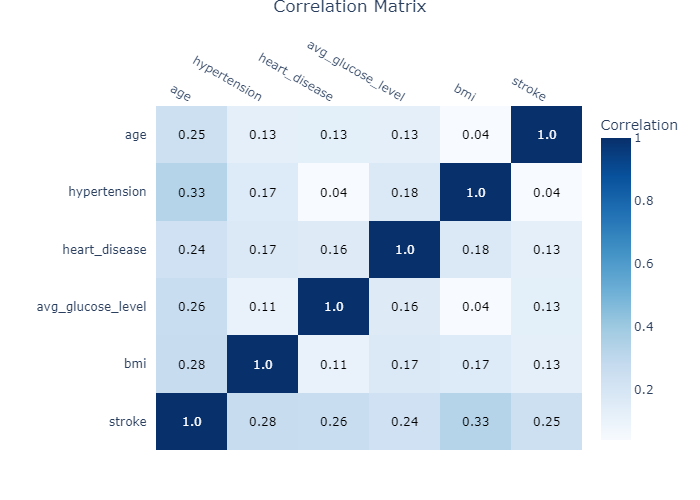

In [10]:
df_corr = df[['age', 'hypertension', 'heart_disease','avg_glucose_level', 'bmi', 'stroke']]
corr_matrix = df_corr.corr()

fig = ff.create_annotated_heatmap(
    x=list(corr_matrix.columns),
    y=list(reversed(corr_matrix.columns)),
    z=corr_matrix.values,
    colorscale='Blues',
    colorbar_title='Correlation',
    annotation_text=corr_matrix.round(2).values,
    showscale=True
)

fig.update_layout(
    title='Correlation Matrix',
    xaxis_title='',
    yaxis_title='',
    title_x=0.5,
    title_y=1,
    margin=dict(l=50, r=50, t=50, b=50),
    height=500,
    width=700,
)


fig.show('png')

- From the plot we can see that there are no highly coorelated features in our amongst the provided features.
- We also have no negatively coorelated features, all of them are positive.
- If we take the highest correlation coefficients among the features we find the value **0.33** to be the highest.
- *Age <> Hypertension* and *Stroke <> BMI* have such coefficients, hence have the highest correlation among the features.

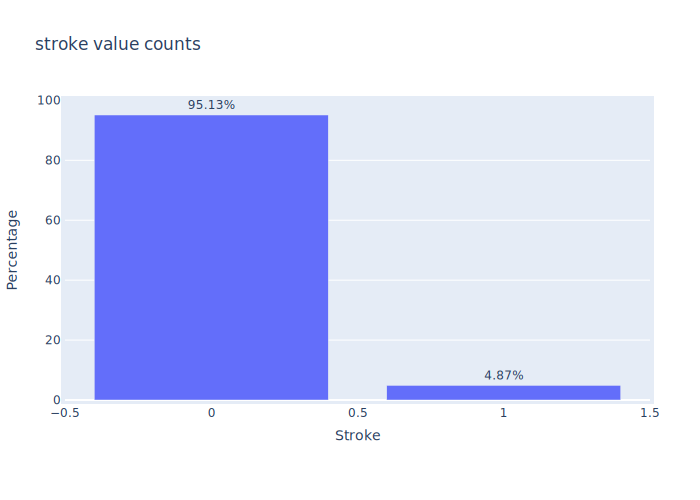

In [11]:
countplot_percentages(df, 'stroke')

From the above plot we can see that there a huge imbalance in the predicted class. We will have to treat this later prior to modelling.

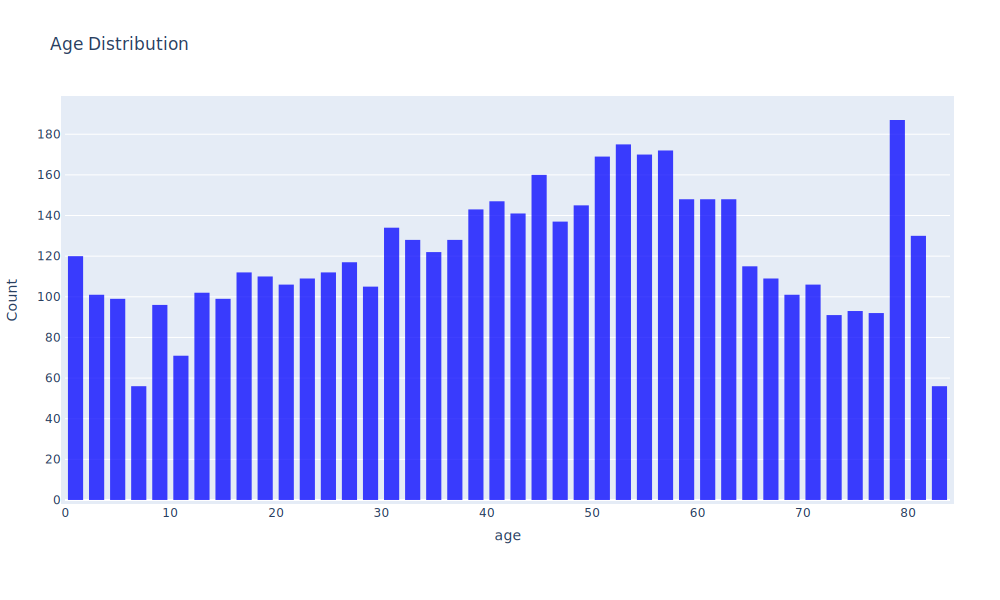

In [12]:
plot_dist(df, 'age')

- The above plot shows us the age distribution in our dataset, we have people from infants up to 84 years old.
- The most occuring age is the age range between 78 and 80.

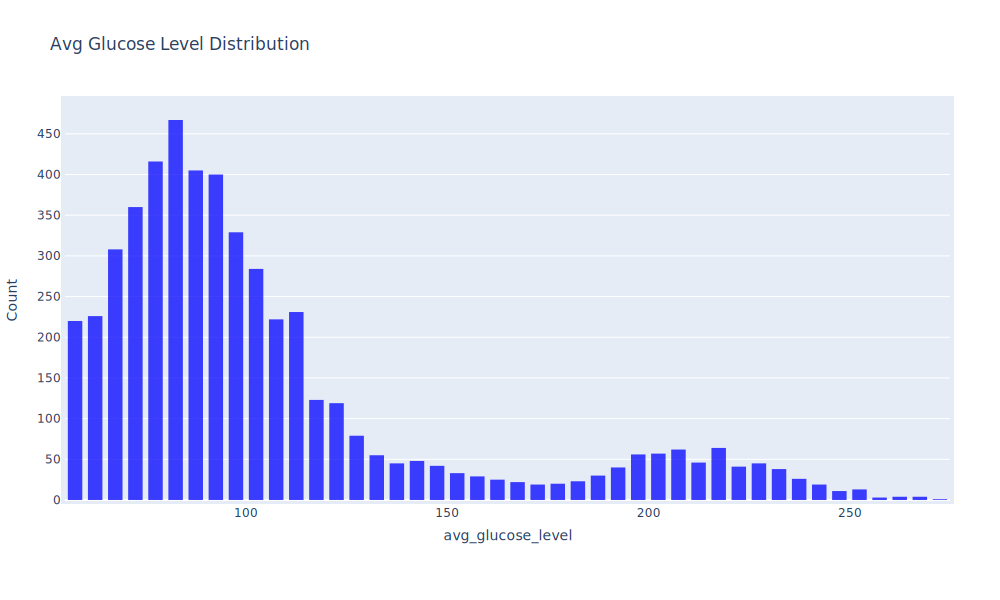

In [13]:
plot_dist(df, 'avg_glucose_level')

- Above we see the average gluscose level distribution, which seems to have some outliers specially on the higher values, but since they are valid Average Glucose Level values we can keep them.
- The most occuring Average Glucose Level is 80 - 85, which is scientifically healthy.

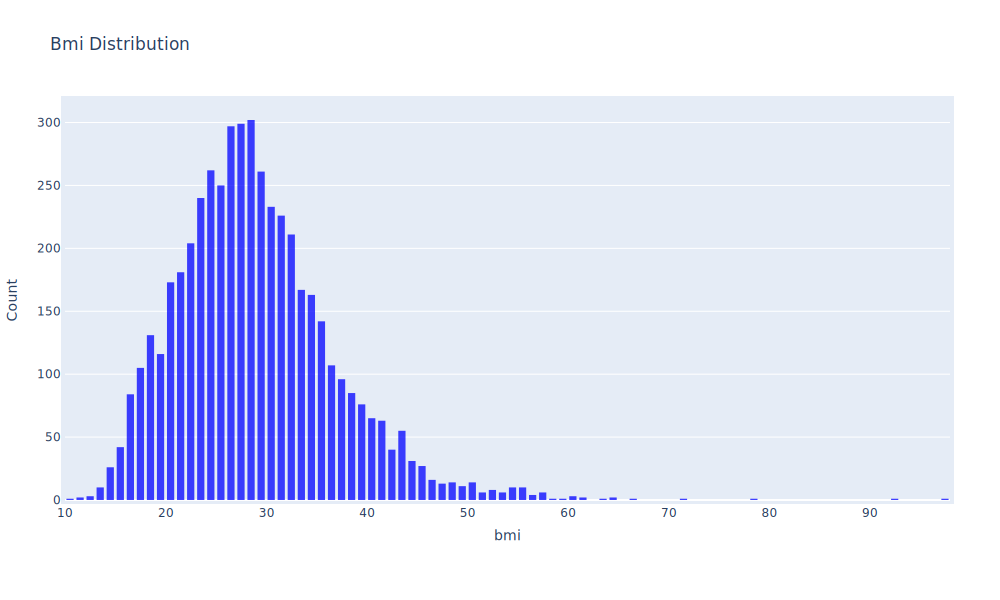

In [14]:
plot_dist(df, 'bmi')

- Above we see the average BMI distribution, which seems to have some outliers specially on the higher values.
- The most occuring Average Glucose Level is 28 - 29, which is not ideal.

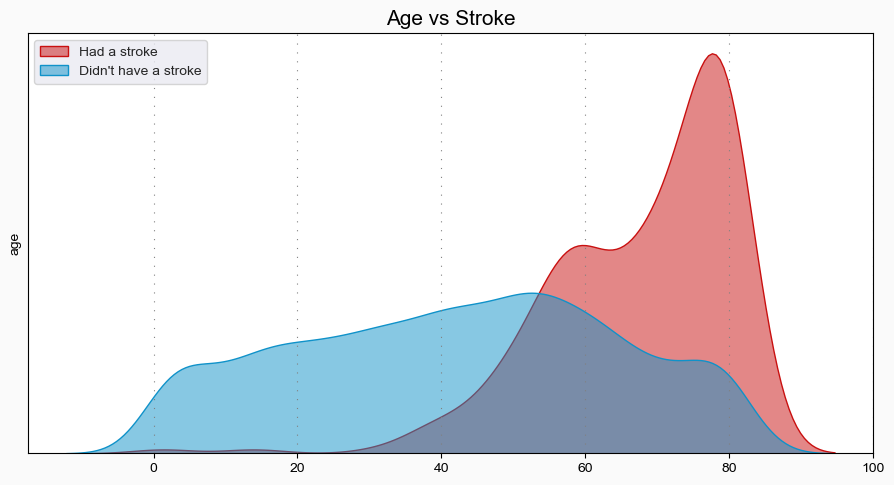

stroke          0          1
age     41.971545  67.728193


In [15]:
plot_distributions(df, ['age'])

From the above plot we can see that people that are older are more vulnerable to stroke.

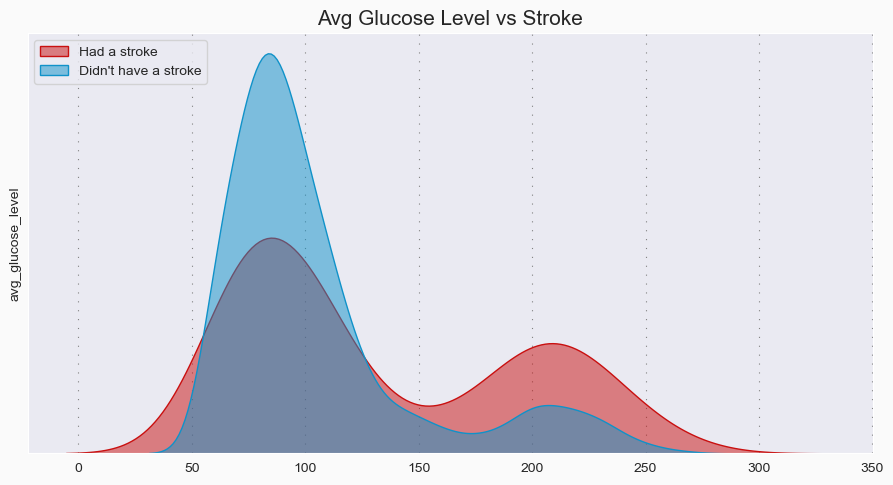

stroke                      0           1
avg_glucose_level  104.795513  132.544739


In [16]:
plot_distributions(df, ['avg_glucose_level'])

From the above plot we can see that people with higher Average Glucose Level values are more vulnerable to stroke, but the difference is not that much significant.

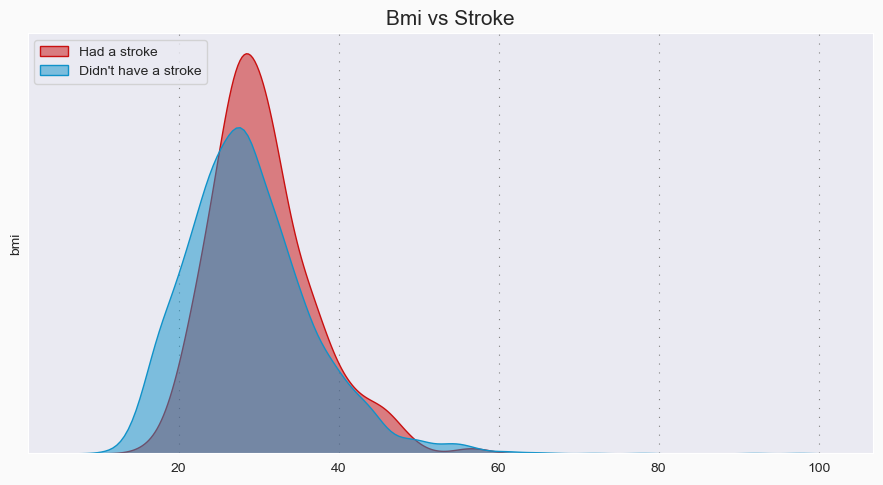

stroke          0          1
bmi     28.823064  30.471292


In [17]:
plot_distributions(df, ['bmi'])

From the above plot we cannot really say that people with higher BMI tend to be vulnerable to stroke, but we can clearly see that for people with BMI less than 20 the vulnerability decreases.

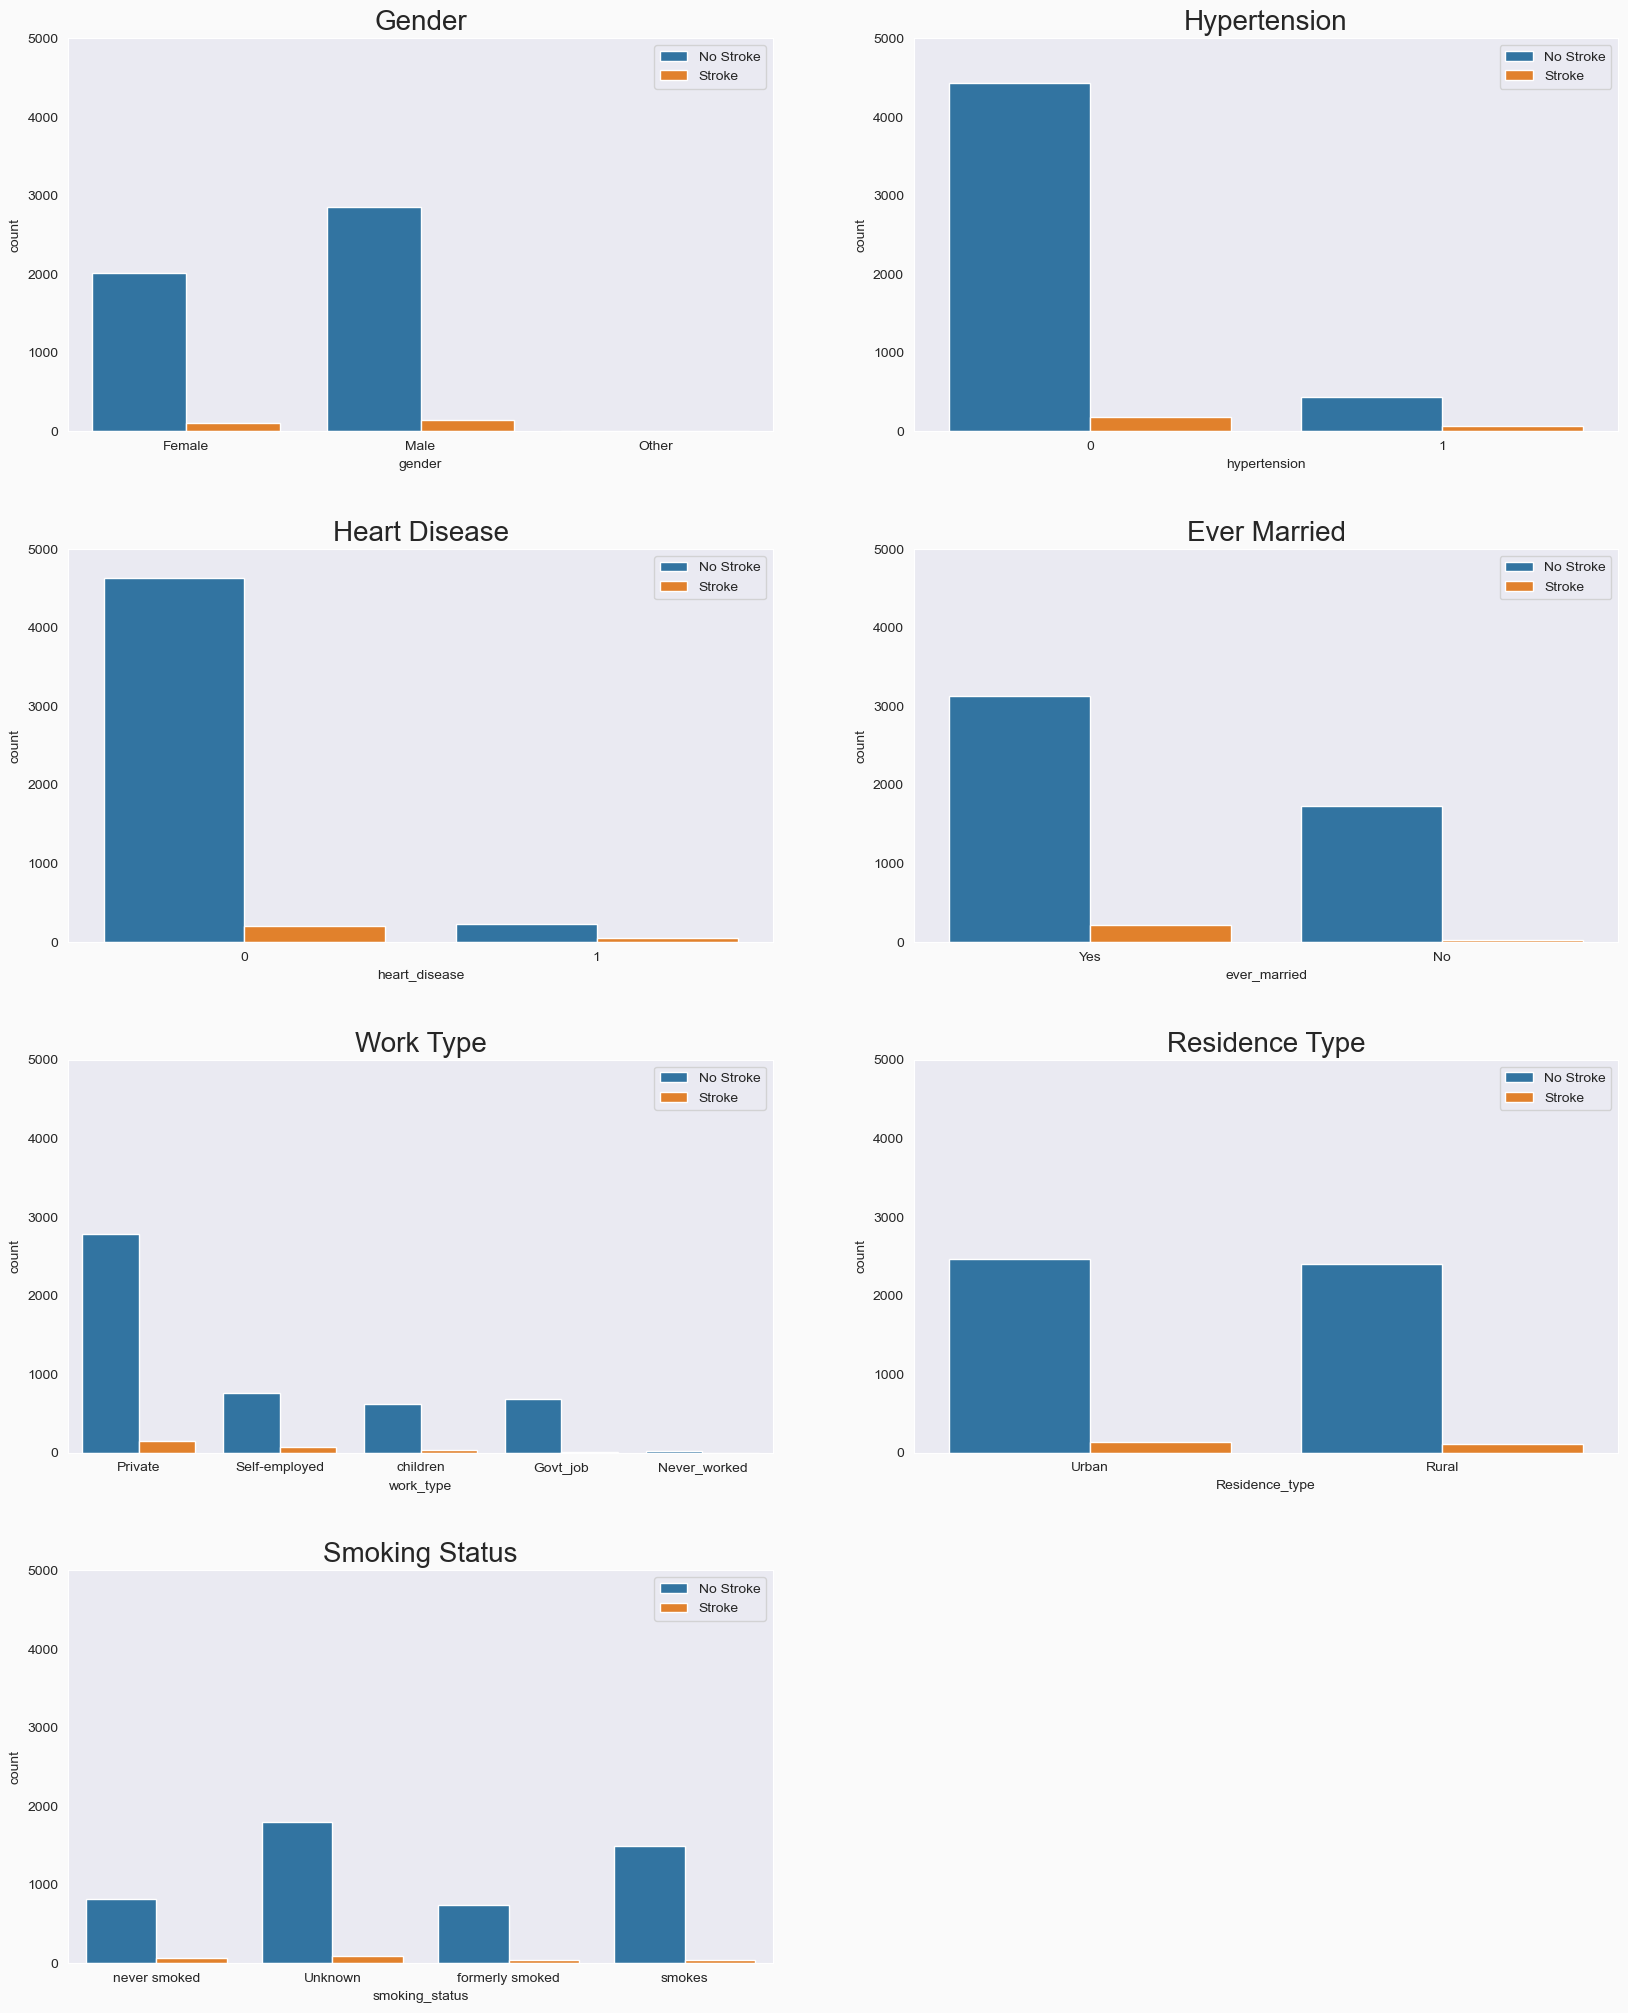

In [18]:
fig = plt.figure(figsize=(20, 25))
fig.patch.set_facecolor('#fafafa')
cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
count = 0

for col in cols:
    count += 1
    ax = fig.add_subplot(4, 2, count)
    ax.set_ylim([0, 5000])
    sns.countplot(x=col, hue='stroke', data=df, ax=ax)
    ax.legend(['No Stroke', 'Stroke'])
    ax.set_title(' '.join([word.capitalize()
                 for word in col.split('_')]), size=20)
    ax.set_xticklabels(df[col].value_counts().index)
    plt.subplots_adjust(hspace=0.3)


From the above plot we can see:
1. There are more male's as compared to other genders.
2. There are way more people with hypertension.
3. Many also claim that they never had a heart disease.
4. Most people in this dataset have been married.
5. Majority of the people in this dataset work on a private job.
6. The count of people living in urban areas vs rular looks almost similar.
7. There are many people with Unknown status in thier smoking status, but other than that people who smoke take the largest share.

The above plots don't really show us what percentage of people are affected with stroke from which categories, so let us explore that using percentages below.

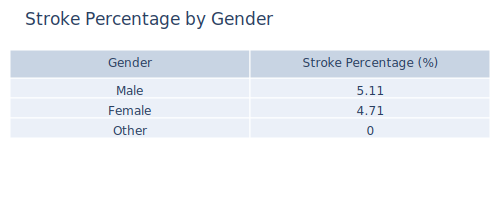

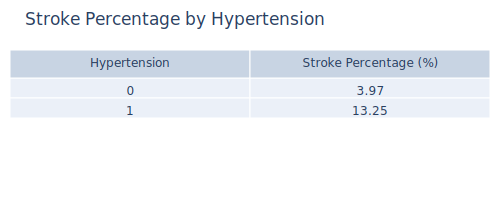

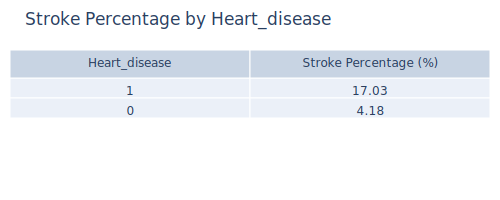

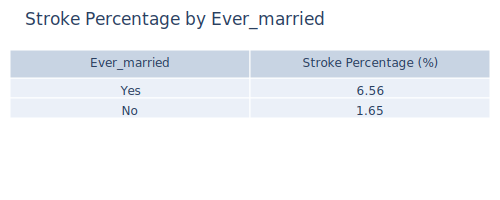

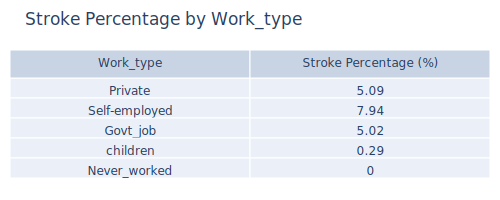

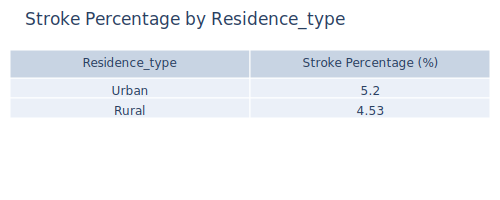

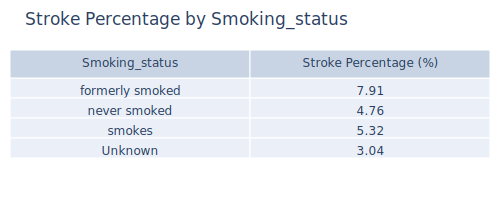

In [19]:
cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in cols:
    tabulate_percentage(df, col)

Form the consecutive tables above we can observe the following:
1. Between Female and Male, we cannot say there is very significant diffrence, but Male are more affected with stroke.
2. In hypertension, people with hypertension have the highest percentages, which shows the prescence of hypertension could lead to stroke.
3. People who have heart disease also have higher stroke percentages, which shows having a heart disease may lead to stroke.
4. People who have been married take the highest share of percentage, so we might say being married may lead to stroke ... there could be many reasons for this, like an unhappy marriage, or conflicts that may arise while in marriage.
5. Among work types people who are self employed have the higher percentage amongst other categories, this might attribute to stress in thier personal work.
6. Among rular and urban residents, urban residents are more vulnerable, but the difference is not that much significant.
7. Amazingly people who have formerly smoked have the higher percentages than that of people who are currently smoking.

## Statistical Inference


- **Null Hypothesis (H0)**: The average avg_glucose_level of patients who have a stroke is equal to the average avg_glucose_level of patients who do not have a stroke.
- **Alternative Hypothesis (HA)**: The average avg_glucose_level of patients who have a stroke is significantly higher than the average avg_glucose_level of patients who do not have a stroke.

In [20]:
population1 = df[df['stroke'] == 1]['avg_glucose_level']
population2 = df[df['stroke'] == 0]['avg_glucose_level']

stat, p_val = t_and_z_test(population1, population2)
print(f'p-value: {p_val}')

result = reject_null(p_val, 0.05)
print('We reject the null hypothesis.') if result else print(
    'We fail to reject the null hypothesis.')

print(
    f'Confidence interval of population 1: {confidence_interval(population1)}')
print(
    f'Confidence interval of population 1: {confidence_interval(population2)}')

p-value: 2.7678105194741054e-21
We reject the null hypothesis.
Confidence interval of population 1: (124.8159518438165, 140.27352606783006)
Confidence interval of population 1: (103.56262389088064, 106.02840264686878)


- **Null Hypothesis (H0)**: The risk of stroke is equal for patients who smoke and patients who do not smoke.
- **Alternative Hypothesis (HA)**: The risk of stroke is significantly higher for patients who smoke than for patients who do not smoke.

In [21]:
population1 = df[(df['smoking_status'] == 'formerly smoked')
                 | (df['smoking_status'] == 'smokes')]['stroke']
population2 = df[df['smoking_status'] == 'never smoked']['stroke']

stat, p_val = t_and_z_test(population1, population2)
print(f'p-value: {p_val}')

result = reject_null(p_val, 0.05)
print('We reject the null hypothesis.') if result else print(
    'We fail to reject the null hypothesis.')

print(
    f'Confidence interval of population 1: {confidence_interval(population1)}')
print(
    f'Confidence interval of population 1: {confidence_interval(population2)}')

p-value: 0.012661347321850926
We reject the null hypothesis.
Confidence interval of population 1: (0.054924189517014235, 0.0788870410684099)
Confidence interval of population 1: (0.03796900495486977, 0.057168415763946295)


- **Null Hypothesis (H0)**: The risk of stroke is equal for patients who live in rural areas and patients who live in urban areas.
- **Alternative Hypothesis (HA)**: The risk of stroke is significantly higher for patients who live in rural areas than for patients who live in urban areas.

In [22]:
population1 = df[df['Residence_type'] == 'Rural']['stroke']
population2 = df[df['Residence_type'] == 'Urban']['stroke']

stat, p_val = t_and_z_test(population1, population2)
print(f'p-value: {p_val}')

result = reject_null(p_val, 0.05)
print('We reject the null hypothesis.') if result else print(
    'We fail to reject the null hypothesis.')

print(
    f'Confidence interval of population 1: {confidence_interval(population1)}')
print(
    f'Confidence interval of population 1: {confidence_interval(population2)}')

p-value: 0.26924758060804893
We fail to reject the null hypothesis.
Confidence interval of population 1: (0.03720738449440445, 0.05348473961060748)
Confidence interval of population 1: (0.043456350904336395, 0.06054981242386084)


## Modelling


### Imports

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import shap
import lime
from functions import fit_and_evaluate_resampled, random_search_resampled, models

### Preprocessing

At the beginning we saw that BMI column had some missing values so let us impute the misiing values with the most frequent(mode) of BMI occurance.

In [24]:
imputer = SimpleImputer(strategy='most_frequent')
df['bmi'] = imputer.fit_transform(df[['bmi']])

In [25]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

After running the Imputer now we have successfully filled the missing values.

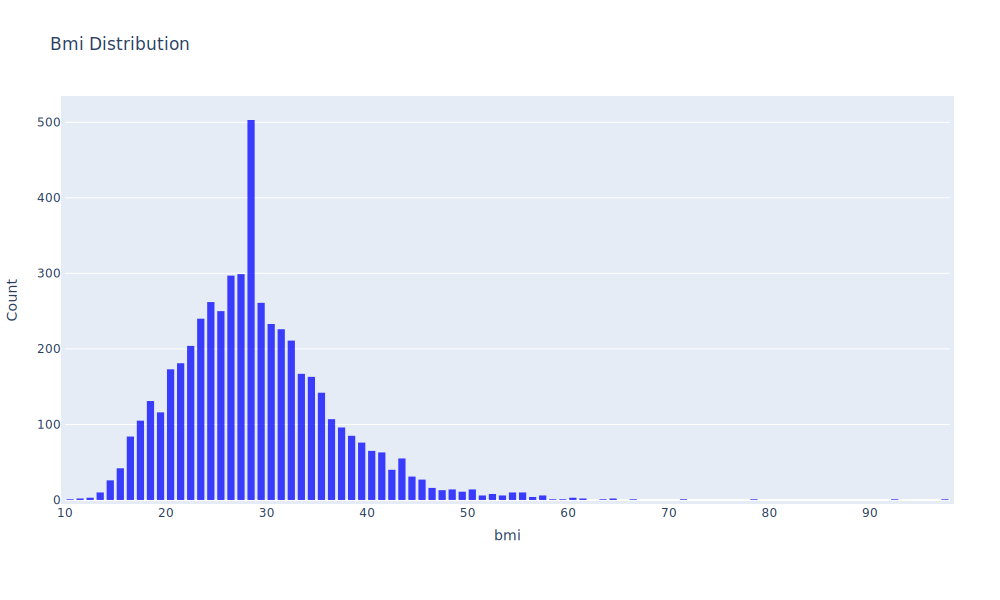

In [26]:
plot_dist(df, 'bmi')

We can see the new BMI distribution here, which shows an even higher occurance for the most occuring BMI value.

In [27]:
encoder = LabelEncoder()
for col in df.select_dtypes('object').columns:
    df[col] = encoder.fit_transform(df[col])
df.head()

gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   
2       1  80.0             0              1             1          2   
3       0  49.0             0              0             1          2   
4       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               1             228.69  36.6               1       1  
1               0             202.21  28.7               2       1  
2               0             105.92  32.5               2       1  
3               1             171.23  34.4               3       1  
4               0             174.12  24.0               2       1

Above we used Label Encoder to change the categorical columns in to numeric ones.

Now let us try to fix the class imbalance in the target feature.

In [28]:
X = df.drop('stroke', axis=1)
y = df['stroke']

y.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Here we are using SMOTE(Synthetic Minority Oversampling Technique) to oversample the minority class that is **1**.

In [29]:
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X, y)

y_resampled.value_counts()

1    4861
0    4861
Name: stroke, dtype: int64

After running SMOTE we can see that we have now got a balanced target class.

While oversampling though we need to be careful not to introduce bias to our models, we will have to validate that later.

In [30]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

Splitting the data in to test and training sets.

In [31]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_resampled = scaler.transform(X_test_resampled)

### Models

**Logistic Regression**

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       973
           1       0.80      0.83      0.82       972

    accuracy                           0.81      1945
   macro avg       0.81      0.81      0.81      1945
weighted avg       0.81      0.81      0.81      1945



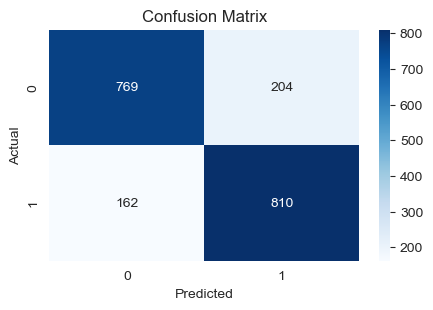

ROC AUC Score:  0.8118362452894827


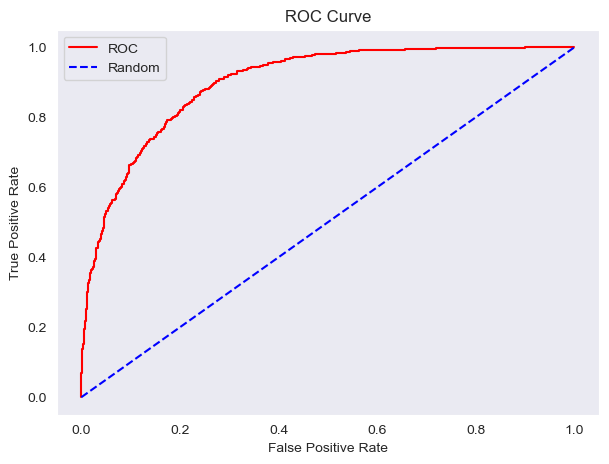

In [32]:
fit_and_evaluate_resampled(LogisticRegression, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled)

Right away we have got decent performances from our Logistic Regression Model, but there is still a room for improvement.

**Support Vector Machine**

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       973
           1       0.84      0.90      0.87       972

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945



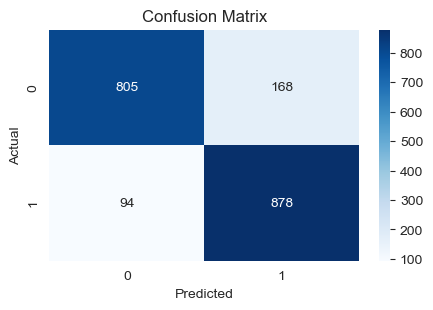

ROC AUC Score:  0.8653151552831809


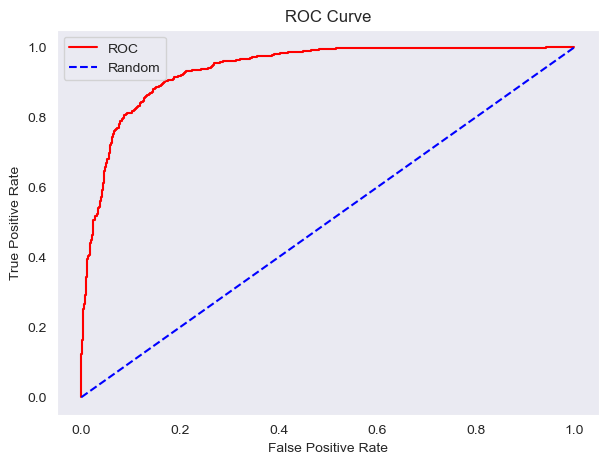

In [33]:
fit_and_evaluate_resampled(svm.SVC, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled, params={'kernel': 'rbf', 'probability': True})

Using the RBF kernel in SVM we have got the above results, which are still decent and better that the performance we got previosly.

**Random Forest**

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       973
           1       0.93      0.96      0.95       972

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



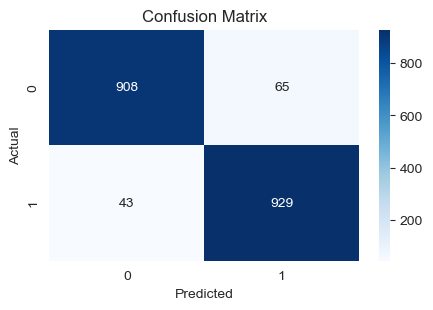

ROC AUC Score:  0.9444788084876014


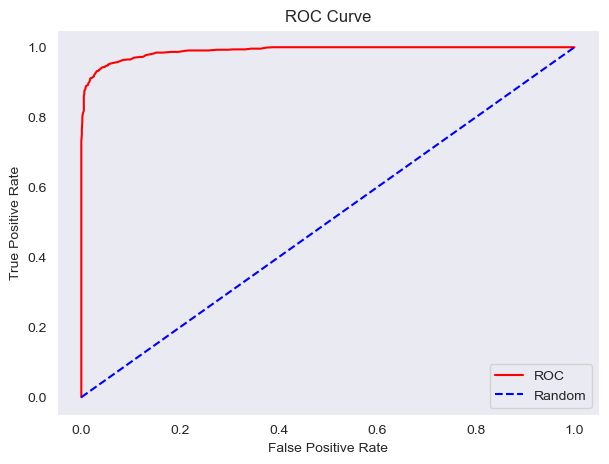

In [34]:
fit_and_evaluate_resampled(RandomForestClassifier, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled, params={'n_estimators': 100})

We have got even better performances by out random Forest model, by only using the number of decision trees(n-estimators) parameter.

**XGBoost**

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       973
           1       0.95      0.96      0.96       972

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



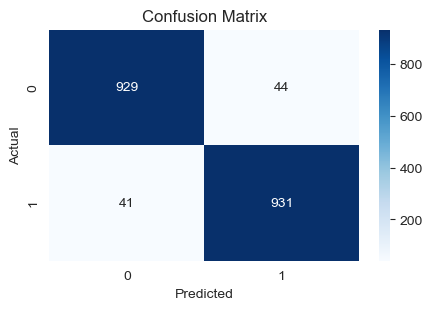

ROC AUC Score:  0.9562989819784384


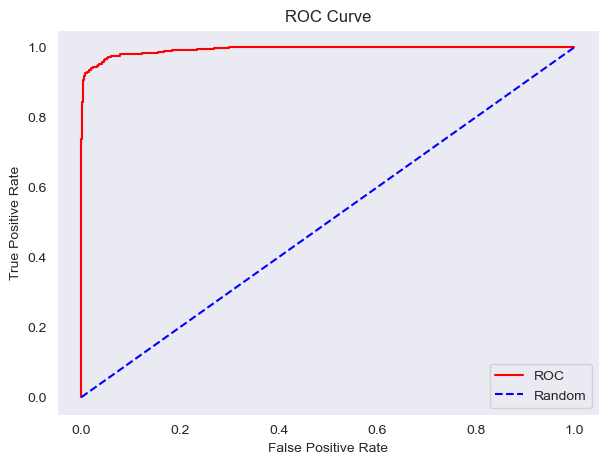

In [35]:
fit_and_evaluate_resampled(xgb.XGBClassifier, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled)

With no hyperparameter tuning our XGBoost model is showing great outcomes, let's also look at the other models.

**CatBoost**

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       973
           1       0.94      0.95      0.94       972

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



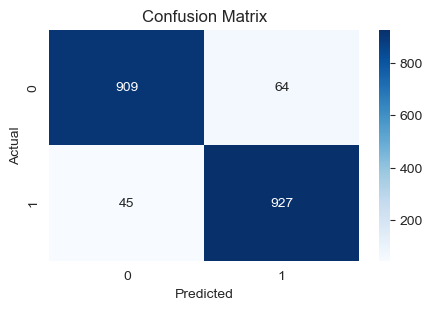

ROC AUC Score:  0.9439638765178334


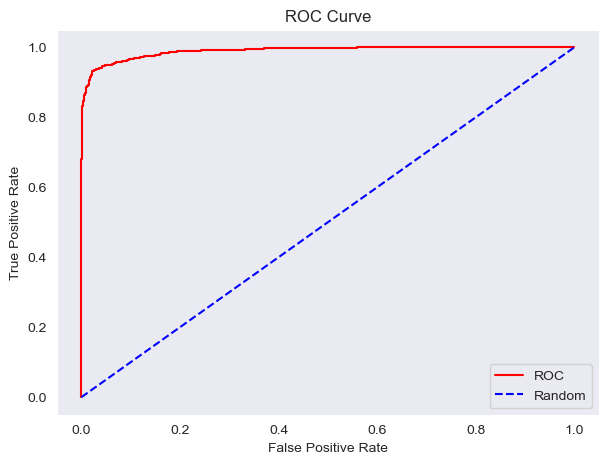

In [36]:
fit_and_evaluate_resampled(cb.CatBoostClassifier, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled, params={'verbose': False})

Eventhough it is not as performant as our XGBoost model the CatBoost model also performs really well.

**LightGBM**

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       973
           1       0.95      0.96      0.95       972

    accuracy                           0.95      1945
   macro avg       0.95      0.95      0.95      1945
weighted avg       0.95      0.95      0.95      1945



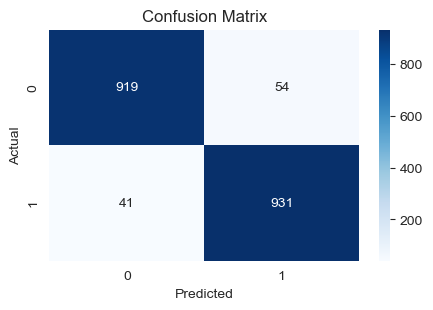

ROC AUC Score:  0.951160235832498


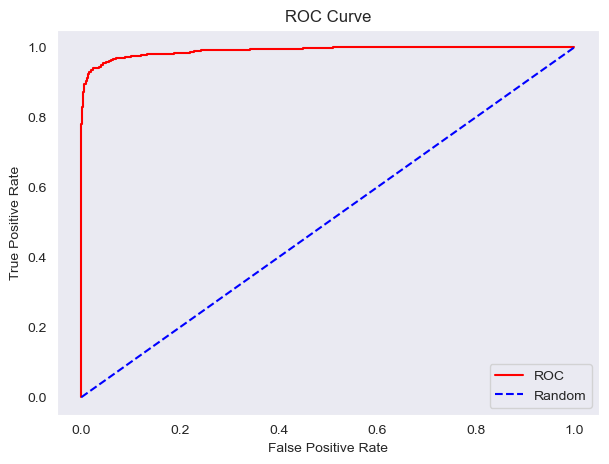

In [37]:
fit_and_evaluate_resampled(lgb.LGBMClassifier, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled, params={'verbose': -1})

This model is still not as performant as the XGBoost model, but has great outcomes as well.

**Hyperparameter Tuning**

**XGBoost**

Best Parameters:  {'subsample': 0.3, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.3}
Best Score:  0.9876314014569776
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       973
           1       0.96      0.96      0.96       972

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



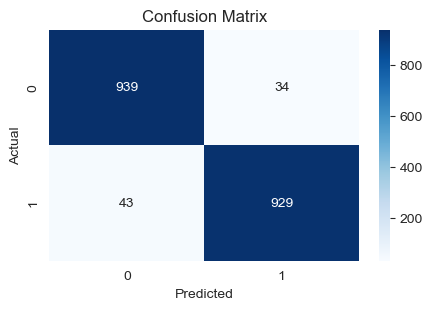

ROC AUC Score:  0.9604089215400167


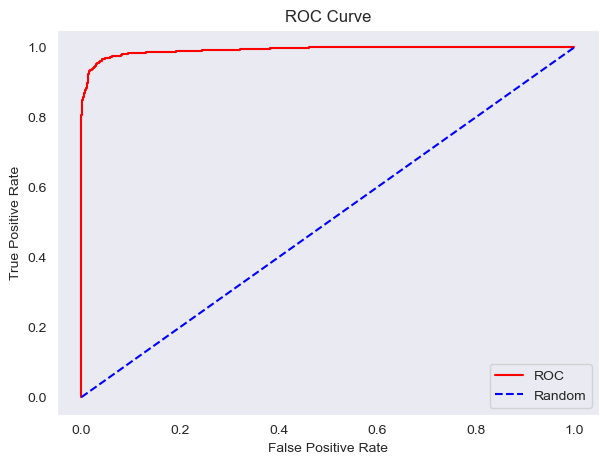

In [38]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7]
}

model = xgb.XGBClassifier()
xgb_best_params = random_search_resampled(model, params, X_train_resampled, y_train_resampled)
fit_and_evaluate_resampled(xgb.XGBClassifier, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled, xgb_best_params)

Hyperparameter tuning has got us slightly better performances as compared to the one above.

The best hyperparameters were: 
* Subsample: Fraction of samples used for training each tree. In this case, **30%** of the data is randomly sampled for each tree.
* n_estimators: The number of boosting rounds (trees) to build. Here, **500** trees will be built.
* Max_depth: The maximum depth of each decision tree. Trees will be limited to a depth of **7** in this case.
* Learning_rate: The step size shrinkage used to prevent overfitting. A learning rate of **0.15** is used here.
* Gamma: Minimum loss reduction required to make a further partition on a leaf node. It helps control the complexity of the trees. A gamma value of **0.1** is used.
* Colsample_bytree: Fraction of features (columns) used for training each tree. Here, **30%** of the features will be randomly selected for each tree.

Best Parameters:  {'learning_rate': 0.1, 'l2_leaf_reg': 0.4, 'iterations': 500, 'depth': 6, 'border_count': 50, 'bagging_temperature': 0}
Best Score:  0.9836441603336151
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       973
           1       0.93      0.96      0.94       972

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



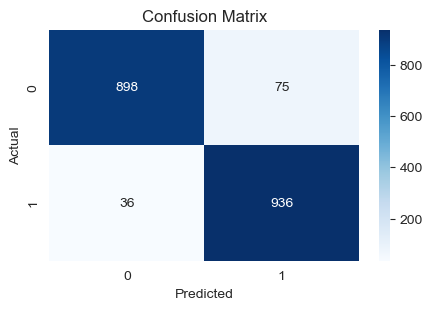

ROC AUC Score:  0.9429408853869284


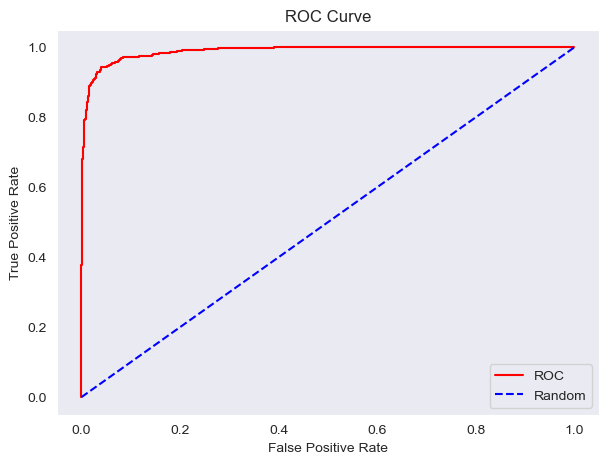

In [39]:
params = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'l2_leaf_reg': [0, 0.1, 0.2, 0.3, 0.4],
    'bagging_temperature': [0, 0.1, 0.2, 0.3, 0.4],
    'border_count': [1, 5, 10, 20, 50]
}

model = cb.CatBoostClassifier(verbose=False)
cb_best_params = random_search_resampled(model, params, X_train_resampled, y_train_resampled)
cb_best_params['verbose'] = False
fit_and_evaluate_resampled(cb.CatBoostClassifier, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled, cb_best_params)

Hyperparameter tuning has no brought significant changes to our model here.

Best Parameters:  {'verbose': -1, 'subsample': 0.5, 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 4, 'learning_rate': 0.2}
Best Score:  0.9873618108298027
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       973
           1       0.96      0.96      0.96       972

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



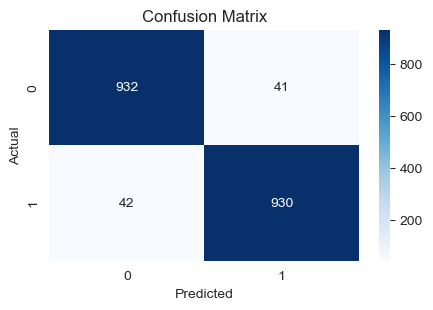

ROC AUC Score:  0.9573262025300394


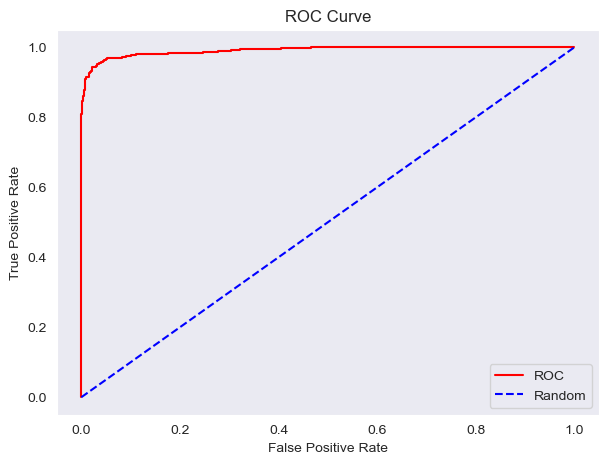

In [40]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'num_leaves': [10, 20, 30, 40, 50],
    'min_child_samples': [10, 20, 30, 40, 50],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7],
    'verbose': [-1],
}

model = lgb.LGBMClassifier()
lgbm_best_params = random_search_resampled(model, params, X_train_resampled, y_train_resampled)
fit_and_evaluate_resampled(lgb.LGBMClassifier, X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled, lgbm_best_params)

Hyperparameter tuning has improved our models performance slightly which is good.

The best hyperparameters were:
- Subsample: Fraction of samples used for training each tree. In this case, 50% of the data is randomly sampled for each tree.
- Num_leaves: The maximum number of leaves (terminal nodes) in each tree. The model will have up to 20 leaves in each tree.
- N_estimators: The number of boosting iterations (trees) to build. Here, 200 trees will be built.
- Min_child_samples: The minimum number of samples required to form a new leaf. This helps control overfitting by requiring a certain number of - samples in each leaf. At least 20 samples are required to create a new leaf.
- Max_depth: The maximum depth of each decision tree. Trees will be limited to a depth of 4 in this case.
- Learning_rate: The step size shrinkage used in the learning process. A learning rate of 0.2 is used here.

**Post Modelling Activities**

**Note:** some visualizations below might not be rendered properly if you are seeing the preview in GitHub, try using the [Google Colab Link](https://colab.research.google.com/drive/1wFoeZx6wCWhBP_Ee8X9q23Fn0dsLFprI?usp=sharing) to see the visualizations. 

In [41]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)

In [42]:
model = xgb.XGBClassifier(**xgb_best_params).fit(X_train_resampled, y_train_resampled)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_resampled.values, feature_names=X_train_resampled.columns, class_names=['Stroke', 'No Stroke'], discretize_continuous=True)

exp = explainer.explain_instance(X_test_resampled[0], model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

In [43]:
X_test_resampled[0]

array([ 1.45072112,  0.34259731, -0.30729016, -0.22318381,  0.62230511,
        0.0353209 ,  1.20393057,  0.57015724,  0.12494411, -1.30923041])

For the above feature set...

In [44]:
exp = explainer.explain_instance(X_test_resampled[8], model.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

In [45]:
X_test_resampled[8]

array([ 1.45072112, -1.77110502, -0.30729016, -0.22318381, -1.6069288 ,
        0.0353209 ,  1.20393057, -0.62278289, -1.54596387, -1.30923041])

For the above feature set...

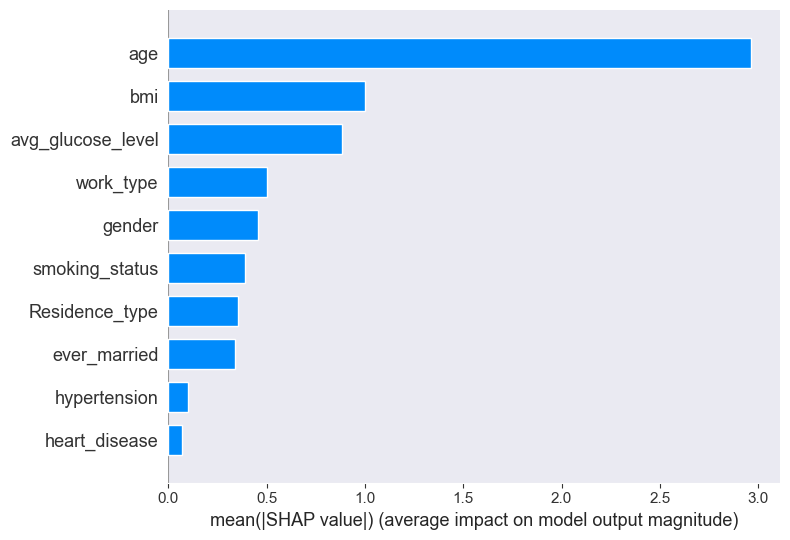

In [46]:
model = xgb.XGBClassifier(**xgb_best_params).fit(X_train_resampled, y_train_resampled)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_resampled)
shap.summary_plot(shap_values, X_train_resampled, plot_type='bar')

Age looks like the most important feature. Next to it being BMI and Average Glucose Level.

In [47]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_resampled.iloc[0,:])

From our force plot we can see that Smoking Status, BMI, Age, and avergae glucose level are dragging the model towards the poitive side, and the rest of the features are dragging it to the negative side.

We can also see that Age here is still themost important feature, since it has the longest bar.

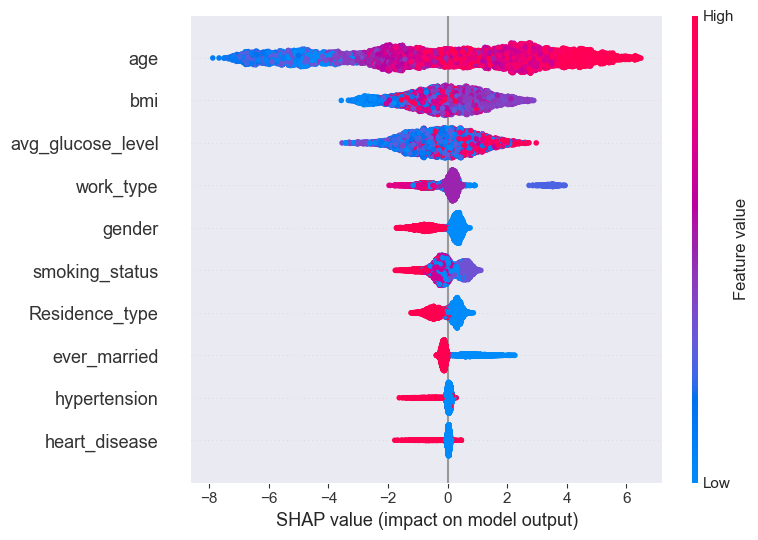

In [52]:
shap.summary_plot(shap_values, X_train_resampled)

Age looks like the most important feature. Next to it being BMI and Average Glucose Level.

In [49]:
import joblib
import random

In [50]:
best_model, best_roc_score = get_model_with_highest_roc_score(models)
print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [53]:
joblib.dump(scaler, 'scaler1.pkl')
joblib.dump(best_model, f'best-model-{round(best_roc_score, 2)}roc-{random.randint(1,100)}.pkl')

['best-model-0.96roc-41.pkl']

## Findings and Summary

- The dataset is not highly correlated, but there is a slight correlation between age and hypertension, and between stroke and BMI.
- The dataset is imbalanced, with a much higher number of people who did not have a stroke than people who did.
- People who are older, have higher average glucose levels, and have BMI less than 20 are more vulnerable to stroke.
- People with hypertension, heart disease, and who are married are more likely to have a stroke.
- Self-employed people and urban residents are also more likely to have a stroke.
- Age looks like the most important factor determining stroke.

Overall, the findings suggest that there are a number of factors that can increase the risk of stroke, including age, average glucose level, BMI, hypertension, heart disease, marital status, and occupation. However, it is important to note that the dataset is imbalanced, so further analysis is needed to confirm these findings. 

We have also done predictive modelling using different types of models with and without hyperparameter tuning. In addition the best model also has been deployed on the web and I have created a simple we app to simulate the results we can get in a simpler way [Check it out](https://stroke-backend.vercel.app/)